In [1]:
import os
import numpy as np
import keras
from keras.preprocessing import image
import matplotlib.pyplot as plt
from keras.layers import *
from keras.models import Model,load_model
from keras.optimizers import *
from keras.losses import *
import keras.backend as K
from keras.callbacks import ModelCheckpoint,LearningRateScheduler,ReduceLROnPlateau
%matplotlib inline
from data_prepare import *

Using TensorFlow backend.


In [2]:
X_PATH=r"F:\matlabPro\imagefusion_noisy_lrr\expand_focus_images"
Y_PATH=r"F:\matlabPro\imagefusion_noisy_lrr\expand_original_images"
x_left,x_right,y=load_dataset(X_PATH,Y_PATH)

X_V_PATH=r"F:\matlabPro\imagefusion_noisy_lrr\focus_images\focus_images"
Y_V_PATH=r"F:\matlabPro\imagefusion_noisy_lrr\original_images"
x_v_left,x_v_right,y_v=load_dataset(X_V_PATH,Y_V_PATH)

In [7]:
y.dtype,y.shape,y.max(),y.min(),y.mean()

(dtype('float32'), (30, 256, 256, 3), 1.0, 0.0, 0.41097343)

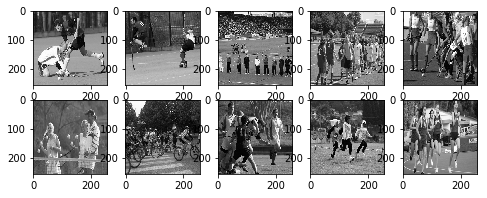

In [9]:
fig=plt.figure(figsize=(8,3))
columns=5
rows=2
for i in range(1,columns*rows+1):
    fig.add_subplot(rows,columns,i)
    plt.imshow(y_v[i-1])
plt.show()

In [4]:
def lr_schedule(epoch):
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

In [5]:
def my_loss(y_true,y_pred):
    return K.sqrt(K.mean(K.square(y_true[...,0:3]-y_pred[...,0:3])))

def conv(inputs,num_filters,kernel_size):
    x=Conv2D(num_filters,kernel_size,padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x 

def net(input_size=(IMAGE_SHAPE[0],IMAGE_SHAPE[0],3)):
    x_left=Input(shape=(input_size))
    x_right=Input(shape=(input_size))
    
    x3=conv(x_left,50,(3,3))
    x4=conv(x_left,10,(4,4))
    x5=conv(x_left,5,(5,5))
    x=concatenate([x3,x4,x5])
    
    x3=conv(x,50,(3,3))
    x4=conv(x,10,(4,4))
    x5=conv(x,5,(5,5))
    x_l=concatenate([x3,x4,x5])
    
    x3=conv(x_right,50,(3,3))
    x4=conv(x_right,10,(4,4))
    x5=conv(x_right,5,(5,5))
    x=concatenate([x3,x4,x5])
    
    x3=conv(x,50,(3,3))
    x4=conv(x,10,(4,4))
    x5=conv(x,5,(5,5))
    x_r=concatenate([x3,x4,x5])
    
    x=concatenate([x_l,x_r])
    
    x3=conv(x,50,(3,3))
    x4=conv(x,10,(4,4))
    x5=conv(x,5,(5,5))
    x=concatenate([x3,x4,x5])
    
    x3=conv(x,50,(3,3))
    x4=conv(x,10,(4,4))
    x5=conv(x,5,(5,5))
    x=concatenate([x3,x4,x5])
    
    x3=conv(x,50,(3,3))
    x4=conv(x,10,(4,4))
    x5=conv(x,5,(5,5))
    x=concatenate([x3,x4,x5])
    
    output=conv(x,3,(3,3))
    model=Model(inputs=[x_left,x_right],outputs=output)
    model.compile(optimizer=SGD(),loss=my_loss)
    
    return model

In [6]:
model=net()

Instructions for updating:
Colocations handled automatically by placer.


In [7]:
data_gen_args = dict(rotation_range=0.2,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.05,
                    zoom_range=0.05,
                    horizontal_flip=True,
                    fill_mode='nearest')
gen=train_generate(10,x_left,x_right,y,data_gen_args)
valid_gen=valid_generate(8,x_v_left,x_v_right,y_v,data_gen_args)

In [8]:
checkpoint = ModelCheckpoint(filepath='model_50_200.hdf5',verbose=1, save_best_only=True)
lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=0.1,
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

#callbacks = [checkpoint, lr_reducer,lr_scheduler]
callbacks = [checkpoint]

In [ ]:
model.fit_generator(gen,steps_per_epoch=50,epochs=200,verbose=1,callbacks=callbacks,validation_data=valid_gen,validation_steps=2)

Epoch 1/200
 2/50 [>.............................] - ETA: 2:38:26 - loss: 0.6814

In [4]:
model=load_model('model_50_100.hdf5',compile=False)

TypeError: TF_SessionRun_wrapper: expected all values in input dict to be ndarray

In [6]:
x_P_PATH=r"G:\图像数据库\多聚焦数据库"
x_p_left,x_p_right=load_dataset(x_P_PATH)

In [7]:
f=model.predict([[x_left[1]],[x_right[1]]])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<function matplotlib.pyplot.show>

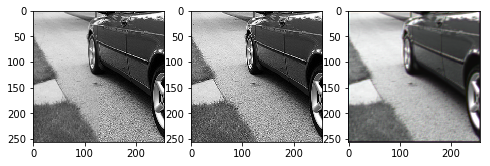

In [8]:
#loss: 0.1903
fig=plt.figure(figsize=(8,3))
fig.add_subplot(131)
plt.imshow(x_left[1])
fig.add_subplot(132)
plt.imshow(y[1])
fig.add_subplot(133)
plt.imshow(f[0])
plt.show

In [6]:
from metric import *

In [12]:
y_v.dtype,y_v.shape

(dtype('float32'), (10, 256, 256, 3))

In [13]:
f=image.load_img('50_15.png')

In [14]:
f=image.img_to_array(f)

In [15]:
f.dtype,f.shape

(dtype('float32'), (256, 256, 3))

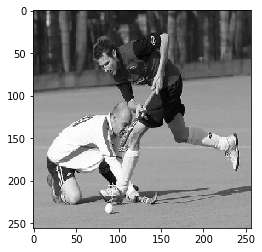

In [19]:
plt.imshow(y_v[0])

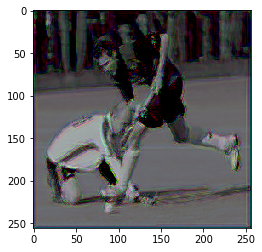

In [22]:
f=f/255
plt.imshow(f)

In [24]:
img_PIL=image.load_img('50_5.png')
f_50_5=image.img_to_array(img_PIL)
f_50_5=f_50_5/255

In [23]:
#0.075566995777412799
x_l_s = torch.from_numpy(np.rollaxis(y_v[0], 2)).float().unsqueeze(0)/255.0
f_s = torch.from_numpy(np.rollaxis(f, 2)).float().unsqueeze(0)/255.0
ssim(x_l_s,f_s).item()

0.9943868517875671

In [25]:
x_l_s = torch.from_numpy(np.rollaxis(y_v[0], 2)).float().unsqueeze(0)/255.0
f_s = torch.from_numpy(np.rollaxis(f_50_5, 2)).float().unsqueeze(0)/255.0
ssim(x_l_s,f_s).item()

0.9997584819793701

In [16]:
assert 2==2 and 3==4 and 4==4,'cc' 

AssertionError: cc